# Differential photometry of asteroid

* 이 노트북을 구글 코랩에서 실행하고자 한다면 [파일] - [드라이브에 사본 저장]을 하여 본인의 소유로 만든 후에 코드를 실행하거나 수정할 수 있습니다.

* 이 파일은 실제 수업에 사용하므로 필요에 따라 예고 없이 변경될 수 있습니다.

* If you have any questions or comments on this document, please email me(Kiehyun.Park@gmail.com).

* 이 파일(문서)는 공교육 현장에서 수업시간에 자유롭게 사용할 수 있으나, 다른 목적으로 사용할 시에는 사전에 연락을 주셔서 상의해 주시기 바랍니다.



천체 관측 중 CCD(charge couple device) 관측 자료를 이용하여 소행성의 차등 측광을 수행하는 방법을 다룹니다.

## 필요한 환경

이 프로젝트를 위해서는 아래의 모듈이 필요합니다.

> numpy, matplotlib, ccdproc, astropy, photutils, version_information



### 구글 코랩에 한글 폰트 설치

matplotlib에서 한글을 사용하기 위해서는 한글 폰트가 필요합니다. 구글 코랩에서 현재의 Jupyter notebook을 실행한다면 아래 코드를 실행 한 후 런타임 다시 시작을 해 줘야 한글을 사용할 수 있을 것입니다.

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

### 런타임 다시 시작

위의 셀을 실행한 다음 반드시 다음 과정을 잊지 마시기 바랍니다.

* [메뉴]-[런타임]-[런터임 다시 시작]

* [메뉴]-[런타임]-[이전 셀 실행]을 해주어야 합니다.

### 한글 폰트 사용

위에서 한글 폰트를 설치하고, 런타임 다시시작을 했다면 구글 코랩에서 폰트 경로를 설정하여 한글 사용이 가능해 집니다.

In [ ]:
#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
#plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

### 모듈 설치 및 버전 확인

아래 셀을 실행하면 이 노트북을 실행하는데 필요한 모듈을 설치하고 파이썬 및 관련 모듈의 버전을 확인할 수 있습니다.

In [ ]:
import importlib, sys, subprocess
packages = "numpy, matplotlib, ccdproc, astropy, photutils, astroquery, ysfitsutilpy, ysphotutilpy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"**** {pkg} module is now being installed.")
    else:
        print(f"******** {pkg} module is already installed.")
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

******** numpy module is already installed.
******** matplotlib module is already installed.
******** ccdproc module is already installed.
******** astropy module is already installed.
******** photutils module is already installed.
******** astroquery module is already installed.
******** ysfitsutilpy module is already installed.
******** ysphotutilpy module is already installed.
******** version_information module is already installed.
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2023-11-23 00:15:54 (UTC = GMT+0000) 
0 Python     3.10.12 64bit [GCC 11.4.0]
1 IPython    7.34.0
2 OS         Linux 5.15.120+ x86_64 with glibc2.35
3 numpy      1.23.5
4 matplotlib 3.7.1
5 ccdproc    2.4.1
6 astropy    5.3.4
7 photutils  1.10.0
8 astroquery 0.4.6
9 ysfitsutilpy 0.2
10 ysphotutilpy 0.1.1
11 version_information 1.0.4


## 데이터 저장

### FITS 파일 저장 폴더 생성

FITS 파일을 저장할 폴더를 "Asteroid_diff_photometry" 이라는 이름으로 생성해 보겠습니다.

* 만약 리눅스 시스템 이라면 shell 명령어로 가능한데, "!"를 붙이면 shell 명령어를 실행할 수 있습니다.
> !mkdir Asteroid_diff_photometry

OS의 영향을 받지 않기 위하여 pathlib을 사용하여 폴더를 생성하겠습니다.

In [ ]:
import os
from pathlib import Path
BASEPATH = Path("./")
save_dir_name = "Asteroid_diff_photometry"
print(f"BASEPATH: {BASEPATH}")

if not (BASEPATH/save_dir_name).exists():
    os.mkdir(str(BASEPATH/save_dir_name))
    print (f"{str(BASEPATH/save_dir_name)} is created...")
else :
    print (f"{str(BASEPATH/save_dir_name)} is already exist...")

BASEPATH: .
Asteroid_diff_photometry is already exist...


### FITS 파일 다운로드

나의 구글 드라이브에 저장된 CCD 관측 파일을 다운받아 보겠습니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

MS Windows에서는 별도로 설치를 해줘야 하며,
구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장된다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하시기 바랍니다.

아래 코드를 실행하면 여러분의 작업영역에 해당 파일을 저장해 줄 것입니다.



In [ ]:
fname1 = "127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits"
fid1 = "1w_vWnJf4slEGx76fPXETuKUaN50rrGh_"
fname2 = "135HERTHA_LIGHT_R_2023-10-10-20-09-49_180sec_RiLA600_STX-16803_-20c_1bin.fits"
fid2 = "1bM6O4rriiZzXEuQhJULbs9pfHClIPIfJ"
fname3 = "135HERTHA_LIGHT_R_2023-10-16-19-13-09_150sec_GSON300_STF-8300M_9c_1bin.fits"
fid3 = "1SQaG4o1Hv5uxGSCoHTQNNaJIJYJWWqQU"

# wget을 이용(나의 구글드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid1}" -O {save_dir_name}/{fname1}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid2}" -O {save_dir_name}/{fname2}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid3}" -O {save_dir_name}/{fname3}

# gdown을 이용(나의 구글드라이브에서 공유한 파일을 다운로드)
#!gdown {fid1} -O {save_dir_name}/{fname1}
#!gdown {fid2} -O {save_dir_name}/{fname2}
#!gdown {fid3} -O {save_dir_name}/{fname3}

--2023-11-23 00:17:34--  https://docs.google.com/uc?export=download&id=1w_vWnJf4slEGx76fPXETuKUaN50rrGh_
Resolving docs.google.com (docs.google.com)... 172.253.122.113, 172.253.122.101, 172.253.122.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.122.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/orqa485j53q75lokklefm14n4su4vakm/1700698650000/11752785994579589476/*/1w_vWnJf4slEGx76fPXETuKUaN50rrGh_?e=download&uuid=be69f631-e4a5-40d5-a14a-30d2e78f8718 [following]
--2023-11-23 00:17:36--  https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/orqa485j53q75lokklefm14n4su4vakm/1700698650000/11752785994579589476/*/1w_vWnJf4slEGx76fPXETuKUaN50rrGh_?e=download&uuid=be69f631-e4a5-40d5-a14a-30d2e78f8718
Resolving doc-0c-6c-docs.googleusercontent.com (doc-0c-6c-docs.googleusercontent.com)... 142.251.167.132, 2607:

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> !ls -l Asteroid_diff_photometry

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [ ]:
!ls -l Asteroid_diff_photometry

total 133160
-rw-r--r-- 1 root root   310385 Nov 22 23:31  127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_asteroid_127.png
-rw-r--r-- 1 root root     9414 Nov 22 23:31 ' 127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_DAOStarfinder_fwhm_6.csv'
-rw-r--r-- 1 root root 34061760 Nov 19 01:00  127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits
-rw-r--r-- 1 root root    10750 Nov 22 23:32  127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_m_inst.csv
-rw-r--r-- 1 root root   322015 Nov 22 23:32  127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_PS1_query.png
-rw-r--r-- 1 root root   359280 Nov 22 23:31  127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_starfinder.png
-rw-r--r-- 1 root root 67204800 Nov 22 23:26  135HERTHA_LIGHT_R_2023-10-10-20-09-49_180sec_RiLA600_STX-16803_-20c_1bin.fits
-rw-r--r-- 1 root root 34061760 Nov 19 00:57  135HERTH

In [ ]:
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.fit*')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('Asteroid_diff_photometry/127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits'), PosixPath('Asteroid_diff_photometry/135HERTHA_LIGHT_R_2023-10-10-20-09-49_180sec_RiLA600_STX-16803_-20c_1bin.fits'), PosixPath('Asteroid_diff_photometry/135HERTHA_LIGHT_R_2023-10-16-19-13-09_150sec_GSON300_STF-8300M_9c_1bin.fits'), PosixPath('Asteroid_diff_photometry/eph-127-127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits.csv')]
len(fpaths): 4


##  FITS handling

### Load files

fits file을  읽어 확인해 보겠습니다.

In [ ]:
from astropy.io import fits

fpath = Path(fpaths[2])
print(f"fpath: {fpath}")
print(f"type(fpath): {type(fpath)}")

hdul = fits.open(str(fpath), unit="adu")

print("type(hdul) :", type(hdul))
print("type(hdul[0]) :", type(hdul[0]))

fpath: Asteroid_diff_photometry/135HERTHA_LIGHT_R_2023-10-16-19-13-09_150sec_GSON300_STF-8300M_9c_1bin.fits
type(fpath): <class 'pathlib.PosixPath'>
type(hdul) : <class 'astropy.io.fits.hdu.hdulist.HDUList'>
type(hdul[0]) : <class 'astropy.io.fits.hdu.image.PrimaryHDU'>


### header

ccds라는 이름에 HDUList들이 리스트 형태로 들어 있습니다. 각각의 hdulist는 2차원 이므로 index는 [0]번만 존재합니다.

In [ ]:
print("type(hdul[0].hedaer) :", type(hdul[0].header))
hdul[0].header

type(hdul[0].hedaer) : <class 'astropy.io.fits.header.Header'>


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3352                                                  
NAXIS2  =                 2532                                                  
FITS-TLM= '2023-11-18T08:55:11' / UT of last modification of this FITS file     
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                150.0 / [s] Exposure duration                          
EXPTIME =                150.0 / [s] Exposure duration                          
DATE-LOC= '2023-11-18T02:11:55.783' / Time of observation (local)               
DATE-OBS= '2023-11-17T17:11:55.783' / Time of observation (UTC)                 
DATE-AVG= '2023-11-17T17:13:11.149' / Averaged midpoint time (UTC)              
XBINNING=                   

header는 key와 value가 들어 있습니다.

In [ ]:
print("hdul[0].hedaer['DATE-OBS'] :", hdul[0].header['DATE-OBS'])
print("type(hdul[0].hedaer['DATE-OBS']) :", type(hdul[0].header['DATE-OBS']))

hdul[0].hedaer['DATE-OBS'] : 2023-11-17T17:11:55.783
type(hdul[0].hedaer['DATE-OBS']) : <class 'str'>


### data

관측 자료는 numpy.ndarray 형태로 들어 있음을 알 수 있습니다.

In [ ]:
print("type(hdul[0].data) :", type(hdul[0].data))
print("hdul[0].data.dtype :", hdul[0].data.dtype)
print("hdul[0].data.shape :", hdul[0].data.shape)
print("hdul[0].data :", hdul[0].data)

type(hdul[0].data) : <class 'numpy.ndarray'>
hdul[0].data.dtype : >f4
hdul[0].data.shape : (2532, 3352)
hdul[0].data : [[5488.5103 5643.993  5607.405  ... 5597.4023 5296.901  5393.7783]
 [5686.813  5568.4663 5528.624  ... 5456.1777 5559.1084 5276.691 ]
 [5753.5747 5488.151  5570.1577 ... 5699.236  5478.6987 5446.0586]
 ...
 [5476.2046 5277.58   5498.8877 ... 5474.3584 5448.752  5418.267 ]
 [5474.3584 5415.4272 5512.9824 ... 5479.693  5644.334  5375.379 ]
 [5526.5186 5473.9536 5373.601  ... 5424.25   5676.565  5592.3154]]


## 별 찾기 (Finding stars)

### 환경 변수 설정

In [ ]:
#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5 * FWHM_INIT # Aperture radius
R_IN = 4 * FWHM_INIT   # Inner radius of annulus
R_OUT = 6 * FWHM_INIT  # Outer radius of annulus
#######################################################

### DAOstar finder

[(photutils.detection)](https://photutils.readthedocs.io/en/stable/detection.html)을 이용하여 별을 찾아낼 수 있습니다. 그러기 위해서는 별의 FWHM과 배경하늘 한계값(threshold)을 설정해야 합니다.


### DAO result

매개변수에 따라 찾아지는 별의 갯수가 달라지게 됩니다.

In [ ]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

fpath = fpaths[0]
print("fpath", (fpath))

hdul =  fits.open(str(fpath), unit="adu")

FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold = thresh,
                        # sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        # roundlo = 0, roundhi = 1.0,  # default values -1 and +1
                        # sigma_radius = 3,           # default values 1.5
                        # ratio = 1.0,                  # 1.0: circular gaussian
                        # exclude_border = True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
print("len(DAOfound) :",len(DAOfound))

fpath Asteroid_diff_photometry/127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits
len(DAOfound) : 58


#### astropy.table

DAOfound의 결과는 astropy.table로 반환됩니다.

In [ ]:
print("type(DAOfound) :", type(DAOfound))
print(DAOfound.colnames)
DAOfound

type(DAOfound) : <class 'astropy.table.table.QTable'>
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']


<QTable length=58>
  id      xcentroid      ...        flux                 mag         
int64      float64       ...      float64              float64       
----- ------------------ ... ------------------ ---------------------
    1 2.1843848604805354 ... 15.044716835021973    -2.943460045137951
    2 3348.7896651058813 ... 14.599931716918945   -2.9108770615441992
    3  1189.678273705989 ...   22.1026611328125    -3.361111413366617
    4 1555.4546865502737 ... 1.0048797130584717 -0.005285196477186749
    5 115.26994546066294 ... 1.3092321157455444  -0.29254162525933475
    6  1483.737487281851 ...  1.095372200012207  -0.09890428640043367
    7 1182.5800936527094 ... 3.0608768463134766    -1.214614640521884
    8 3117.7855808336913 ...  3.647139310836792   -1.4048808812568747
    9  2647.184517923724 ... 1.6274290084838867   -0.5287551322769822
   10 1400.5509388338814 ...  3.548220634460449    -1.375026542942551
  ...                ... ...                ...                   ...
   49  2168.125199753524 ...  1.144343614578247   -0.1463911265013283
   50 1720.7455489958325 ... 109.10838317871094   -5.0946453005859995
   51 2304.2522100757483 ...  5.221917629241943   -1.7945750424018045
   52 1797.0334625684206 ... 1.8020312786102295   -0.6394058123483581
   53  939.7593645669145 ... 3.3928797245025635   -1.3264211611149435
   54  939.9674986517324 ... 3.2491536140441895   -1.2794256111992206
   55 1628.4008182562707 ... 11.871101379394531     -2.68622753470827
   56 2758.3838061075376 ... 1.3773072957992554   -0.3475771200337564
   57  2.198370495688346 ... 14.543468475341797   -2.9066699846816224
   58 3348.8318843527973 ...  14.66594409942627   -2.9157750632750234

#### csv 저장하기

In [ ]:
DAOfound.write(f"{BASEPATH / save_dir_name}/ {fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                            overwrite = True,
                            format='ascii.fast_csv')

#### daraframe으로 저장

In [ ]:
df = DAOfound.to_pandas()
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


id    xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
0    1     2.184385     2.146958   0.406142    0.149830   -0.021784    49   
1    2  3348.789665     2.194655   0.423972   -0.147737    0.001009    49   
2    3  1189.678274    22.809125   0.347951   -0.041527   -0.666885    49   
3    4  1555.454687    25.190825   0.937421    0.622851   -0.136445    49   
4    5   115.269945    52.536960   0.974147   -0.437660    0.099196    49   
5    6  1483.737487    76.026159   0.274486   -0.886326    0.504203    49   
6    7  1182.580094   101.643589   0.301753   -0.139103   -0.856975    49   
7    8  3117.785581   184.380695   0.987817   -0.420529    0.094775    49   
8    9  2647.184518   251.116398   0.598109    0.077868    0.233341    49   
9   10  1400.550939   296.842081   0.375536   -0.091592   -0.568622    49   
10  11  2269.005148   299.528966   0.730730   -0.036582   -0.302892    49   
11  12  1815.433803   399.782890   0.397626   -0.036330   -0.935025    49   
12  13  2384.109406   433.620461   0.413569   -0.114782   -0.540394    49   
13  14  3272.961616   556.298385   0.406994    0.033131   -0.762560    49   
14  15   246.340750   636.802487   0.320280   -0.114216   -0.758799    49   
15  16  2631.989603   683.137382   0.442782   -0.386283   -0.789497    49   
16  17   976.894672   716.102158   0.320963   -0.057961   -0.623532    49   
17  18   453.556006   731.060825   0.442848   -0.026192   -0.650077    49   
18  19  2243.350307   887.652860   0.357152   -0.229353   -0.725665    49   
19  20   453.651625   928.957271   0.426527    0.222511   -0.772909    49   
20  21  2074.555020   953.672799   0.353119   -0.171889   -0.639912    49   
21  22   265.998901   972.655810   0.428719   -0.078696   -0.788177    49   
22  23  2819.466643  1020.731900   0.365331   -0.245841   -0.954069    49   
23  24  1479.353488  1025.269328   0.353988   -0.104698   -0.686804    49   
24  25  2079.051192  1054.081740   0.326720   -0.100013   -0.783495    49   
25  26  1216.424884  1128.799569   0.396601   -0.096273   -0.658624    49   
26  27  1741.888855  1148.085451   0.333161   -0.111794   -0.781641    49   
27  28   848.887089  1153.538874   0.457602   -0.260303   -0.825702    49   
28  29  1598.558130  1270.474126   0.384875   -0.067303   -0.676712    49   
29  30   241.902472  1313.708541   0.360596    0.848115   -0.171948    49   
30  31  2306.075811  1391.151631   0.266823   -0.296442   -0.175389    49   
31  32   288.810033  1451.572919   0.295153   -0.149246   -0.917591    49   
32  33  2722.751825  1467.076206   0.445654   -0.264503   -0.533142    49   
33  34   629.448707  1507.761217   0.314857   -0.103538   -0.900203    49   
34  35  2725.189681  1540.102290   0.482003   -0.211251   -0.545492    49   
35  36  2150.290175  1552.855893   0.404172    0.260284    0.482890    49   
36  37  1300.208999  1628.273402   0.316476   -0.659963   -0.418095    49   
37  38   796.593229  1692.523271   0.351897    0.303773   -0.650002    49   
38  39   742.124078  1697.299194   0.612590    0.099806    0.752726    49   
39  40  1758.576032  1749.021399   0.267814   -0.210283   -0.831113    49   
40  41  1385.367895  1817.829787   0.314957   -0.098127   -0.726701    49   
41  42   670.533726  1834.511910   0.401329   -0.120291   -0.540471    49   
42  43   134.407708  1934.417760   0.644702   -0.822460    0.161322    49   
43  44   241.847429  1946.163726   0.675788    0.704497    0.261315    49   
44  45  2108.266312  1965.459484   0.543074    0.166978   -0.990698    49   
45  46   526.054041  1969.445791   0.601499   -0.027991   -0.592442    49   
46  47  1863.210228  2088.276131   0.516665    0.192622   -0.528593    49   
47  48  2102.640304  2153.377166   0.227745    0.588981   -0.467531    49   
48  49  2168.125200  2237.639690   0.538490    0.457992   -0.120353    49   
49  50  1720.745549  2247.959357   0.357977   -0.118469   -0.796565    49   
50  51  2304.252210  2327.976297   0.351117    0.131631   -0.772104    49   


### 이미지에서 좌표

#### 픽셀 좌표

In [ ]:
import numpy as np
pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
apert = CAp(pos, r=R_AP)
#apert
annul = CAn(positions=pos, r_in=4*FWHM, r_out=6*FWHM)
#annul

#### WCS 좌표

In [ ]:
from astropy.wcs import WCS

wcs = WCS(hdul[0].header)
print("wcs :", wcs)
print("type(wcs) :", type(wcs))
print("dir(wcs) :", dir(wcs))

wcs.pixel_n_dim

Set MJD-AVG to 60265.717490 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60265.717490 from DATE-AVG'.


wcs : WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 29.821801964  14.3747322771  
CRPIX : 1676.5  1266.5  
CD1_1 CD1_2  : 0.000254881672318  1.90279006232e-06  
CD2_1 CD2_2  : -1.86630029508e-06  0.000254949098901  
NAXIS : 3352  2532
type(wcs) : <class 'astropy.wcs.wcs.WCS'>
dir(wcs) : ['__abstractmethods__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_all_pix2world', '_all_world2pix', '_array_converter', '_as_mpl_axes', '_denormalize_sky', '_det2im', '_fix_ctype', '_fix_pre2012_scamp_tpv', '_fix_scamp', '_get_components_and_classes', '_get_naxis', '_init_kwargs', '_naxis', '_normali

2

#### tag stars on image

In [ ]:
from astropy.visualization import ZScaleInterval, ImageNormalize

def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image, **kwargs), origin='lower')


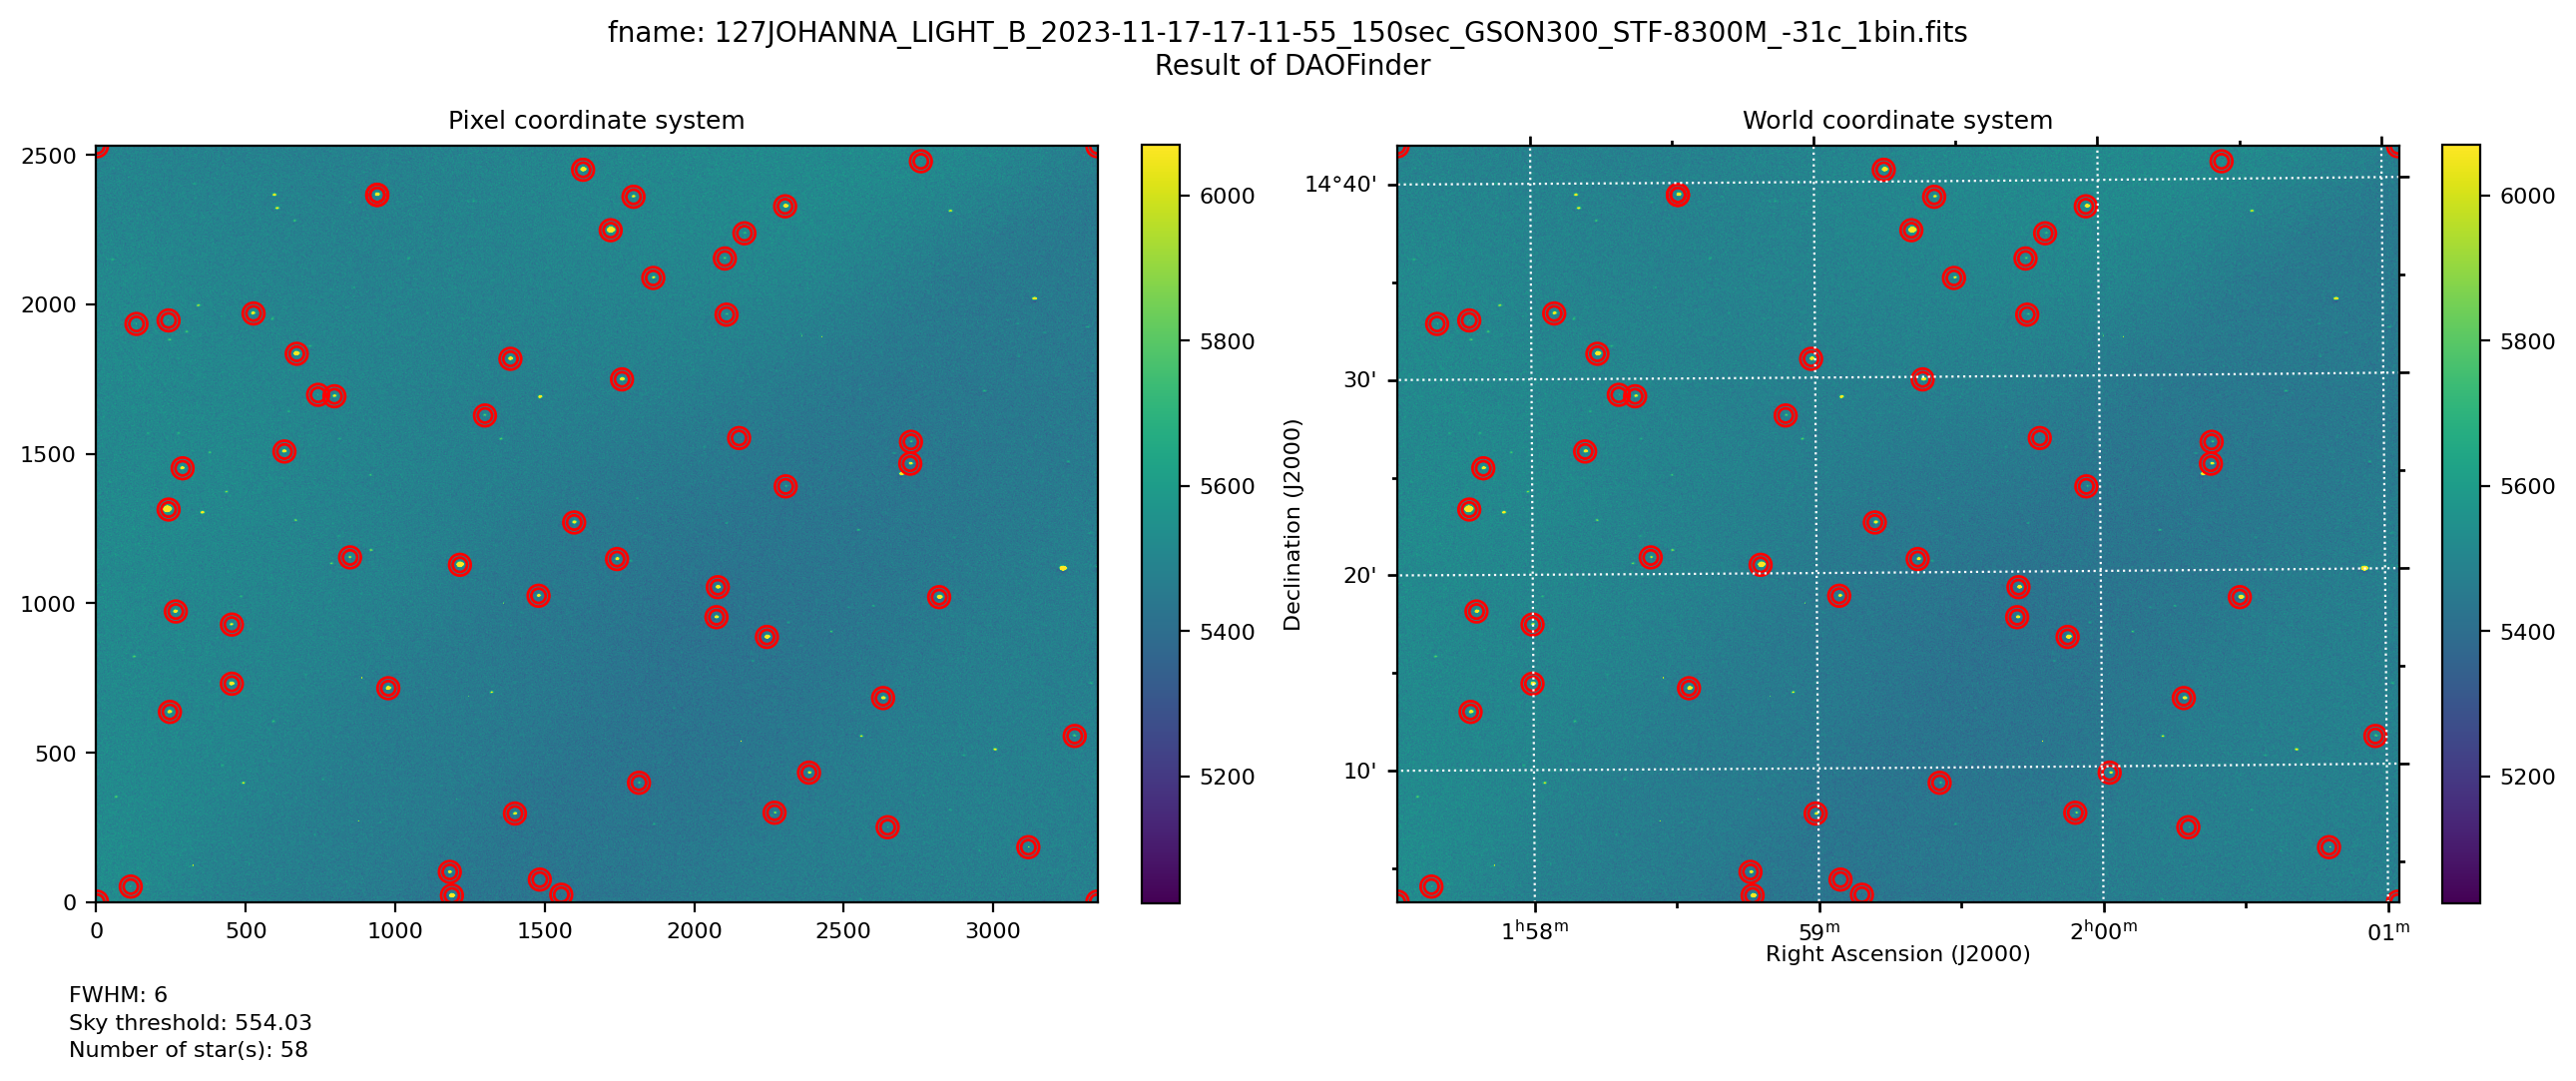

In [ ]:
fig_set = plt.figure(figsize=(13, 5.2))

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

annul.plot(ax1, color="r")
annul.plot(ax2, color="r")

cbar1 = plt.colorbar(im1, ax = ax1, fraction=0.035, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=0.035, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

ax1.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_starfinder.png")

plt.show()
#plt.close()

## 소행성 찾기

### 관측소 정보 및 변수 설정


In [ ]:
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u

def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image, **kwargs), origin='lower')

#####################################################################
# Our object (will be queried to JPL HORIZONS)
OBJID = '127' #

# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon = location = EarthLocation(lon=127.005 * u.deg,
                                 lat=37.308889 * u.deg,
                                 height=101 * u.m)
observatory_code = "P64"

# It is used as a rough estimate, so no need to be accurate:
#PIX2ARCSEC = 1.24*u.arcsec

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

#Mag_UP = 17
#######################################################

### 관측 시각 얻기

In [ ]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.jplhorizons import Horizons

# D.2. Find the observation time and exposure time to set the obs time
t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
t_expos = hdul[0].header['EXPTIME'] * u.s
t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time

print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")

t_start: 2023-11-17T17:11:55.783, t_expos: 150.0 s, t_middle: 2023-11-17T17:13:10.783


### 소행성 좌표 정보

관측소 정보와 관측 파일의 header에 있는 정보로 소행성 좌표를 얻어보자.

In [ ]:
# D.3. Query the ephemerides of this target! See below why I used '900486', not '41P'.
obj = Horizons(id=OBJID, location=observatory_code, epochs=t_middle.jd)
obj_ephem = obj.ephemerides()

obj_ephem

<Table masked=True length=1>
      targetname            datetime_str       ...  PABLon  PABLat
         ---                    ---            ...   deg     deg  
        str21                  str24           ... float64 float64
--------------------- ------------------------ ... ------- -------
127 Johanna (A872 VB) 2023-Nov-17 17:13:10.783 ... 36.6507   1.724

### dataframe으로 저장하기

여러개의 관측 데이터를 다룰 때는 dataframe이 유용할 수 있으므로 아래와 같이 dataframe으로 변환해 보자.

In [ ]:
import pandas as pd
df_eph = obj_ephem.to_pandas()
df_eph
df_eph.to_csv(f"{save_dir_name}/eph-{OBJID}-{fpath.name}.csv")
if (BASEPATH/save_dir_name/f'eph-{OBJID}-{fpath.name}.csv').exists() :
    print(f"{save_dir_name}/eph-{OBJID}-{fpath.name}.csv is created...")

Asteroid_diff_photometry/eph-127-127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits.csv is created...


### 이미지에서 소행성 좌표 찾기

In [ ]:
pos_sky_targ_init = SkyCoord(df_eph['RA'], df_eph["DEC"], **SKYC_KW)
pos_pix_targ_init = SkyCoord(df_eph['RA'], df_eph["DEC"],
						**SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
pos_pix_targ_init = np.array(pos_pix_targ_init).T
print(pos_pix_targ_init)

[[1598.52243898 1270.77307614]]


여러개의 소행성에 대해 좌표를 구할때는다음과 같이 for ~ loop 을 사용할 수 있다.

In [ ]:
# pos_pix_targ_inits = []
# for i, row in df_eph.iterrows():
#     # print("row['targetname'] :", row['targetname'],
#     #       "row['datetime_str'] :", row['datetime_str'],
#     #       "row['datetime_jd'] :", row['datetime_jd'],
#     #       "row['RA'] :", row['RA'],
#     #       "row['DEC'] :", row['DEC'],
#     #       )
#     wcs = WCS(hdul[0].header)
#     pos_pix_targ_init = SkyCoord(row['RA'], row["DEC"],
# 						**SKYC_KW).to_pixel(wcs)
#     #print("type(pos_pix_targ_init) :", type(pos_pix_targ_init))
#     pos_pix_targ_inits.append(pos_pix_targ_init)
# #print(pos_pix_targ_inits)

# df_eph['pos_pix_targ_init'] = pos_pix_targ_inits
# print("df_eph['pos_pix_targ_init'] :", df_eph['pos_pix_targ_init'])

### tag asteroid on image

In [ ]:
targ_ap = CAp(pos_pix_targ_init,
        r=R_AP)
targ_an = CAn(pos_pix_targ_init,
        r_in=R_IN,
        r_out=R_OUT)

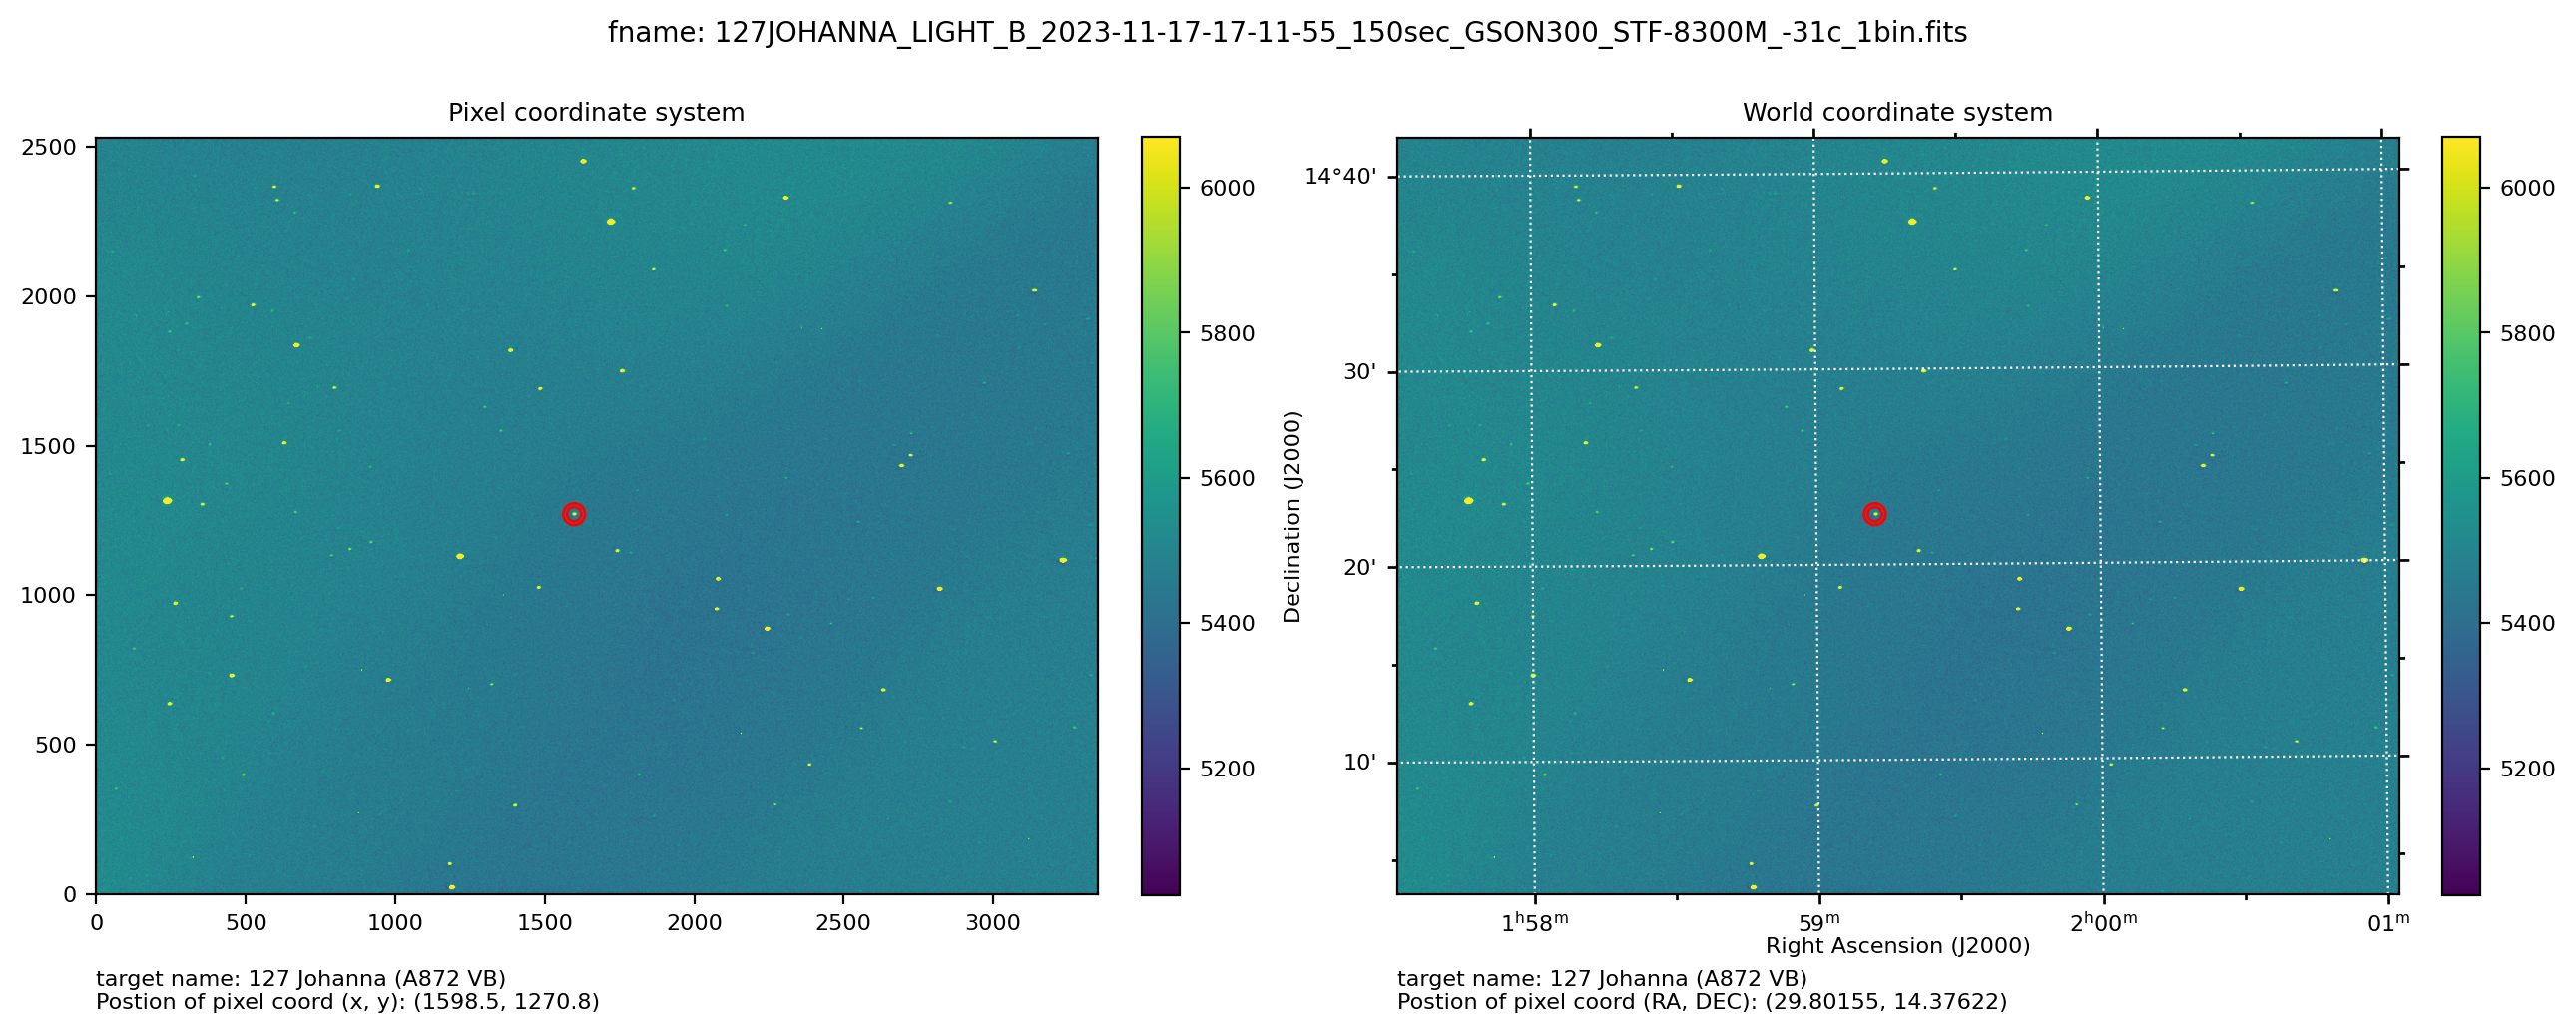

In [ ]:
fig_set = plt.figure(figsize=(13, 5.2))

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

targ_an.plot(ax1, color="r")
targ_an.plot(ax2, color="r")

cbar1 = plt.colorbar(im1, ax = ax1, fraction=0.035, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=0.035, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}", fontsize=10,)

ax1.annotate(f"target name: {df_eph['targetname'][0]}\nPostion of pixel coord (x, y): ({pos_pix_targ_init[0][0]:.01f}, {pos_pix_targ_init[0][1]:.01f})", fontsize=8,
    xy=(0, 0), xytext=(0, -0.1), va='top', ha='left',
    xycoords='axes fraction')

ax2.annotate(f"target name: {df_eph['targetname'][0]}\nPostion of pixel coord (RA, DEC): ({df_eph['RA'][0]}, {df_eph['DEC'][0]})", fontsize=8,
    xy=(0, 0), xytext=(0, -0.1), va='top', ha='left',
    xycoords='axes fraction')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_asteroid_{OBJID}.png")
plt.show()
#plt.close()

## instrumental magnitude

### sky estimation

sky value를 구하는 알고리즘은 여러가지가 있다. 이를 함수로 만들어 사용하자.

In [ ]:
import numpy as np
from astropy.stats import sigma_clip

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.
    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)
    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------
    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma,
                                maxiters=sky_iter, #iters=sky_iter,
                                )
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej

### rdnoise and gain

CCD spec에서 readout noise 값과 gain 값을 알아보자. fits header에 들어있지 않지만, 데이터 처리하는 과정에서 fits header에 넣어 주기도 한다.

In [ ]:
# "STF-8300M"
hdul[0].header["GAIN"] = 0.37,
hdul[0].header["RDNOISE"] = 9.3

 #"STX-16803"
#hdul[0].header["GAIN"] = 1.27
#hdul[0].header["RDNOISE"] = 9.0

#hdul[0].header["PIXSCALE"] = 0.92819

# It is used as a rough estimate, so no need to be accurate:
PIX2ARCSEC = hdul[0].header["PIXSCALE"]
rdnoise = hdul[0].header["RDNOISE"]
gain    = hdul[0].header["GAIN"]

print(rdnoise, gain, PIX2ARCSEC)

9.3 0.37 0.9281925000000001


### aperture sum

구경 안의 픽셀 값들의 합은 aperture_photometry 함수로 쉽게 구할 수 있다.

In [ ]:
from photutils.aperture import aperture_photometry as apphot
apphot_result = apphot(hdul[0].data, apert, method='center')
print(type(apphot_result))
apphot_result
df_apphot = apphot_result.to_pandas()
df_apphot

<class 'astropy.table.table.QTable'>


id      xcenter      ycenter  aperture_sum
0    1     2.184385     2.146958  6.598742e+05
1    2  3348.789665     2.194655  6.612815e+05
2    3  1189.678274    22.809125  2.160239e+06
3    4  1555.454687    25.190825  1.387853e+06
4    5   115.269945    52.536960  1.415420e+06
5    6  1483.737487    76.026159  1.367399e+06
6    7  1182.580094   101.643589  1.488553e+06
7    8  3117.785581   184.380695  1.418459e+06
8    9  2647.184518   251.116398  1.381245e+06
9   10  1400.550939   296.842081  1.488568e+06
10  11  2269.005148   299.528966  1.413140e+06
11  12  1815.433803   399.782890  1.405810e+06
12  13  2384.109406   433.620461  1.460421e+06
13  14  3272.961616   556.298385  1.413848e+06
14  15   246.340750   636.802487  1.567291e+06
15  16  2631.989603   683.137382  1.521448e+06
16  17   976.894672   716.102158  1.678170e+06
17  18   453.556006   731.060825  1.660428e+06
18  19  2243.350307   887.652860  1.851357e+06
19  20   453.651625   928.957271  1.454550e+06
20  21  2074.555020   953.672799  1.510305e+06
21  22   265.998901   972.655810  1.532699e+06
22  23  2819.466643  1020.731900  1.888655e+06
23  24  1479.353488  1025.269328  1.486737e+06
24  25  2079.051192  1054.081740  1.591212e+06
25  26  1216.424884  1128.799569  4.033470e+06
26  27  1741.888855  1148.085451  1.491019e+06
27  28   848.887089  1153.538874  1.427931e+06
28  29  1598.558130  1270.474126  1.519050e+06
29  30   241.902472  1313.708541  6.870804e+06
30  31  2306.075811  1391.151631  1.384359e+06
31  32   288.810033  1451.572919  1.518163e+06
32  33  2722.751825  1467.076206  1.479285e+06
33  34   629.448707  1507.761217  1.536087e+06
34  35  2725.189681  1540.102290  1.389438e+06
35  36  2150.290175  1552.855893  1.395263e+06
36  37  1300.208999  1628.273402  1.418894e+06
37  38   796.593229  1692.523271  1.471877e+06
38  39   742.124078  1697.299194  1.413648e+06
39  40  1758.576032  1749.021399  1.606847e+06
40  41  1385.367895  1817.829787  1.586340e+06
41  42   670.533726  1834.511910  1.953238e+06
42  43   134.407708  1934.417760  1.417106e+06
43  44   241.847429  1946.163726  1.396302e+06
44  45  2108.266312  1965.459484  1.425255e+06
45  46   526.054041  1969.445791  1.493845e+06
46  47  1863.210228  2088.276131  1.456986e+06
47  48  2102.640304  2153.377166  1.419781e+06
48  49  2168.125200  2237.639690  1.419160e+06
49  50  1720.745549  2247.959357  5.540975e+06
50  51  2304.252210  2327.976297  1.591503e+06
51  52  1797.033463  2359.813138  1.438558e+06
52  53   939.759365  2365.921375  1.558799e+06
53  54   939.967499  2366.036009  1.547641e+06
54  55  1628.400818  2450.167223  1.936132e+06
55  56  2758.383806  2478.561305  1.412255e+06
56  57     2.198370  2528.800590  6.654094e+05
57  58  3348.831884  2528.818963  6.537805e+05

### aperture area

구경의 넓이 구하기

In [ ]:
ap_area   = apert.area
ap_area

254.46900494077323

### 모든 별 측광하기

DAOfinder로 찾은 모든 별에 대하여 기기등급을 구할 수 있다.

<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: Runt

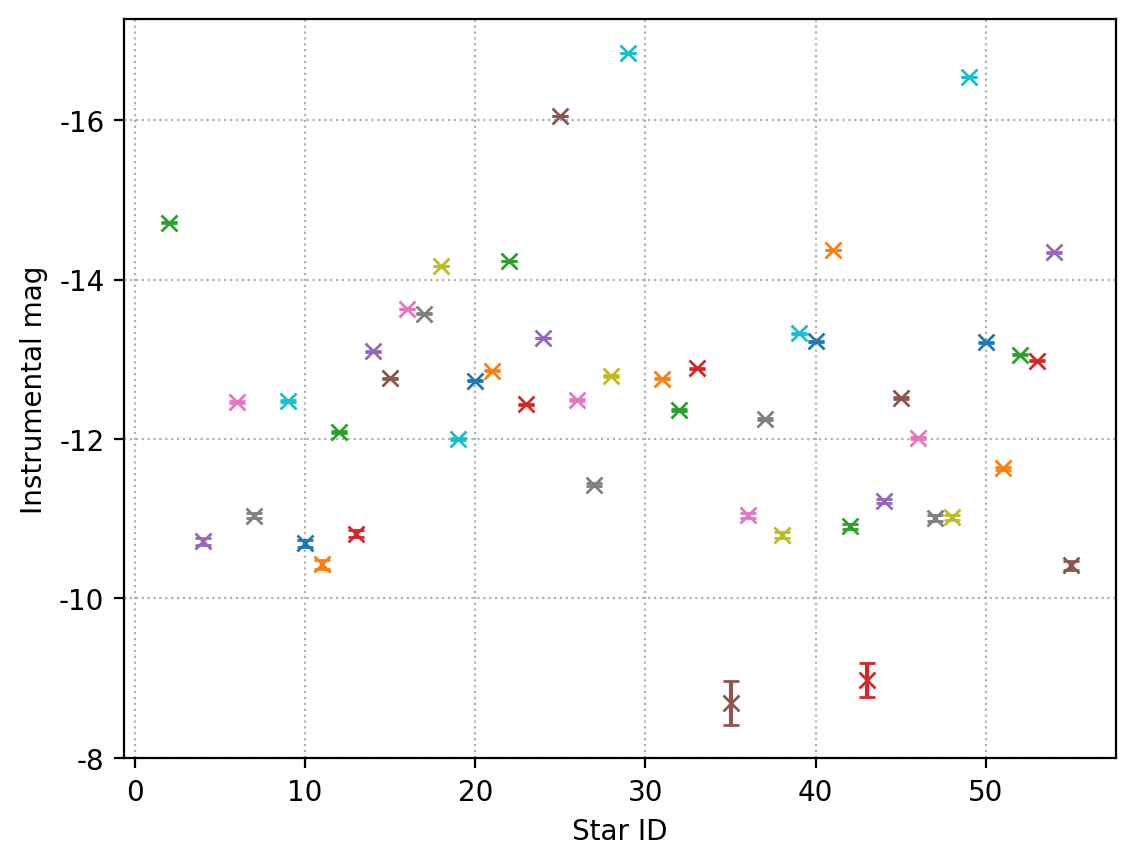

In [ ]:
# since our `annul` has many elements,
mask_apert = (apert.to_mask(method='center'))
mask_annul = (annul.to_mask(method='center'))

mag_ann  = np.zeros(len(apphot_result))
merr_ann = np.zeros(len(apphot_result))

#Returns magnitude from flux.
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/ np.log(10) * ferr / flux
    return m_inst, merr

fig, ax = plt.subplots()

for i in range(len(apphot_result)):
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')

    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    # print(i, msky, sky_std, nsky, nrej)
    # print(i, mag_ann[idx], merr_ann[idx])
    try:
        ax.errorbar(i, mag_ann[i], yerr=merr_ann[i],
                    marker='x',
                    #ms=10,
                    capsize=3)
    except:
        continue

ax.invert_yaxis()
#ax.set_ylim(ymin=-13, ymax=-10)
plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.grid(ls=':')
plt.show()

In [ ]:
for i, row in df_apphot.iterrows():
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')

    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann, merr_ann = mag_inst(flux_star, flux_err)
    df_apphot.loc[i, 'msky'] = msky
    df_apphot.loc[i, 'sky_std'] = sky_std
    df_apphot.loc[i, 'nsky'] = nsky
    df_apphot.loc[i, 'nrej'] = nrej
    df_apphot.loc[i, 'flux_star'] = flux_star
    df_apphot.loc[i, 'flux_err'] = flux_err
    df_apphot.loc[i, 'mag_inst'] = mag_ann
    df_apphot.loc[i, 'merr_inst'] = merr_ann

df_apphot.to_csv(f"{str(BASEPATH / save_dir_name)}/{fpath.stem}_m_inst.csv")
#df_apphot

<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
<ipython-input-33-5d57292e86ef>:10: Runt

## 표준화(Standardization)

### 중심 좌표 구하기 (RA, DEC)

In [ ]:
import ysfitsutilpy as yfu
import ysphotutilpy as ypu

cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header,
                                      center_of_image=True)
cent_coord

Set MJD-AVG to 60265.717490 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60265.717490 from DATE-AVG'.


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (29.82180196, 14.37473228)>

###  도입 에러 구하기

In [ ]:
offset_RA = (cent_coord.ra.to(u.deg) - hdul[0].header['RA']*u.deg).to(u.arcmin)
offset_DEC = (cent_coord.dec.to(u.deg) - hdul[0].header['DEC']*u.deg).to(u.arcmin)
altaz = AltAz(obstime=t_middle, location=Suwon)
cent_aa = cent_coord.transform_to(altaz)
offset_AZ = (cent_aa.az.to(u.deg) - hdul[0].header['CENTAZ']*u.deg).to(u.arcmin)
offset_ALT = (cent_aa.alt.to(u.deg) - hdul[0].header['CENTALT']*u.deg).to(u.arcmin)


### 이미지의 FOV에 해당하는 좌표(RA, DEC)

In [ ]:
# Get the radius of the smallest circle which encloses all the pixels
rad = yfu.fov_radius(header=hdul[0].header, unit=u.deg)
print("rad: {}".format(rad))

Set MJD-AVG to 60265.717490 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60265.717490 from DATE-AVG'.


rad: 0.3227621683971018 deg


### 차등 측광을 위한 별 목록


#### PanSTARRS1 Catalogue 얻어 오기

In [ ]:
# Initialize PanSTARRS1 class
q = ypu.PanSTARRS1(
    ra=cent_coord.ra.value,
    dec=cent_coord.dec.value,
    radius=rad,
    column_filters={"gmag":"11.0..15.0", "e_gmag":"<0.10"},
)

# Query to the website (VizieR)
# This is where the most of the time is spent.
q.query()

/usr/local/lib/python3.10/dist-packages/ysphotutilpy/queryutil.py:716: UserWarning: ra is not astropy Quantity: Assuming deg unit
  warn(f"{k} is not astropy Quantity: Assuming deg unit")
/usr/local/lib/python3.10/dist-packages/ysphotutilpy/queryutil.py:716: UserWarning: dec is not astropy Quantity: Assuming deg unit
  warn(f"{k} is not astropy Quantity: Assuming deg unit")


<Table length=41>
   _r       RAJ2000       DEJ2000    ...  yKmag  e_yKmag  yFlags 
              deg           deg      ...   mag     mag           
float64     float64       float64    ... float64 float32  int32  
-------- ------------- ------------- ... ------- ------- --------
0.042573  29.850904940  14.342825120 ... 13.9864  0.0067   115000
0.109658  29.737300230  14.447707290 ... 13.7979  0.0012   115000
0.110453  29.935831680  14.374356560 ... 13.9650  0.0028   115000
0.121852  29.701135470  14.340365870 ...      --      --        0
0.123076  29.699627980  14.341009450 ...      --      --   114720
0.125464  29.844632540  14.498233780 ... 11.9076  0.0010 16777496
0.133505  29.723304010  14.468124020 ... 13.7920  0.0048   115000
0.164432  29.988564090  14.405525000 ... 13.6926  0.0052   115000
0.169860  29.727672810  14.231443530 ... 12.5634  0.0020   115000
     ...           ...           ... ...     ...     ...      ...
0.279909  29.550830720  14.472071750 ... 14.2251  0.0010   115000
0.288035  29.569730530  14.527629230 ... 13.7187  0.0035   115000
0.289331  29.976267510  14.127141790 ... 13.1428  0.0037   115000
0.294169  29.715070290  14.650154370 ... 14.0905  0.0045   115000
0.297873  30.121965910  14.310210630 ... 10.9085  0.0217       24
0.302306  29.811814340  14.676882580 ...      --      --        0
0.310065  29.507842210  14.314602210 ... 13.4814  0.0017   115000
0.314621  29.989642080  14.644151340 ... 11.8195  0.0010       24
0.317293  29.495657270  14.404212570 ... 12.1516  0.0033   115000
0.321976  29.819985610  14.696702510 ... 13.9493  0.0033   115000

#### 별 필터링

In [ ]:
# # Only select the stars within 50-pixel bezel in the FOV.
q.select_xyinFOV(hdul[0].header,
                 #bezel=50
                 bezel=5*FWHM_INIT*PIX2ARCSEC
                 )

# # Remove objects not suitable for differential photometry (see description below)
q.drop_for_diff_phot(drop_by_Kron=True)

Set MJD-AVG to 60265.717490 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60265.717490 from DATE-AVG'.


 35 objects remaining:   6 masked out of  41 based on [27.845775 27.845775]-pixel bezel.
 29 objects remaining:   6 masked out of  35 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 21 objects remaining:   8 masked out of  29 based on the Kron magnitude criterion.


In [ ]:
# Remove redundant columns, remove objects with too few observations:
#q.select_filters(filter_names=['g', 'r', 'i'], n_mins=10)
# You can try a list of ``n_mins``:
#q.select_filters(filter_names=['g', 'r', 'i'], n_mins=[10, 10, 10])

In [ ]:
q_stars_orig = q.queried.copy()
pos_stars_orig = np.array([q_stars_orig["x"], q_stars_orig["y"]]).T
q_stars_orig

q.drop_star_groups(crit_separation = 6 * FWHM_INIT)
q_stars_diropped = q.queried.copy()

q_stars = q.queried.copy()
pos_sky_targ_init, pos_pix_targ_init

pos_stars = np.array([q_stars["x"], q_stars["y"]]).T

df_stars = q_stars_diropped.to_pandas()

        Use `photutils.psf.SourceGrouper` instead. [ysphotutilpy.queryutil]
        Use `photutils.psf.SourceGrouper` instead.


 21 objects remaining:   0 masked out of  21 based on DAOGROUP with 36.000-pixel critical separation..


#### 별 tag 하기

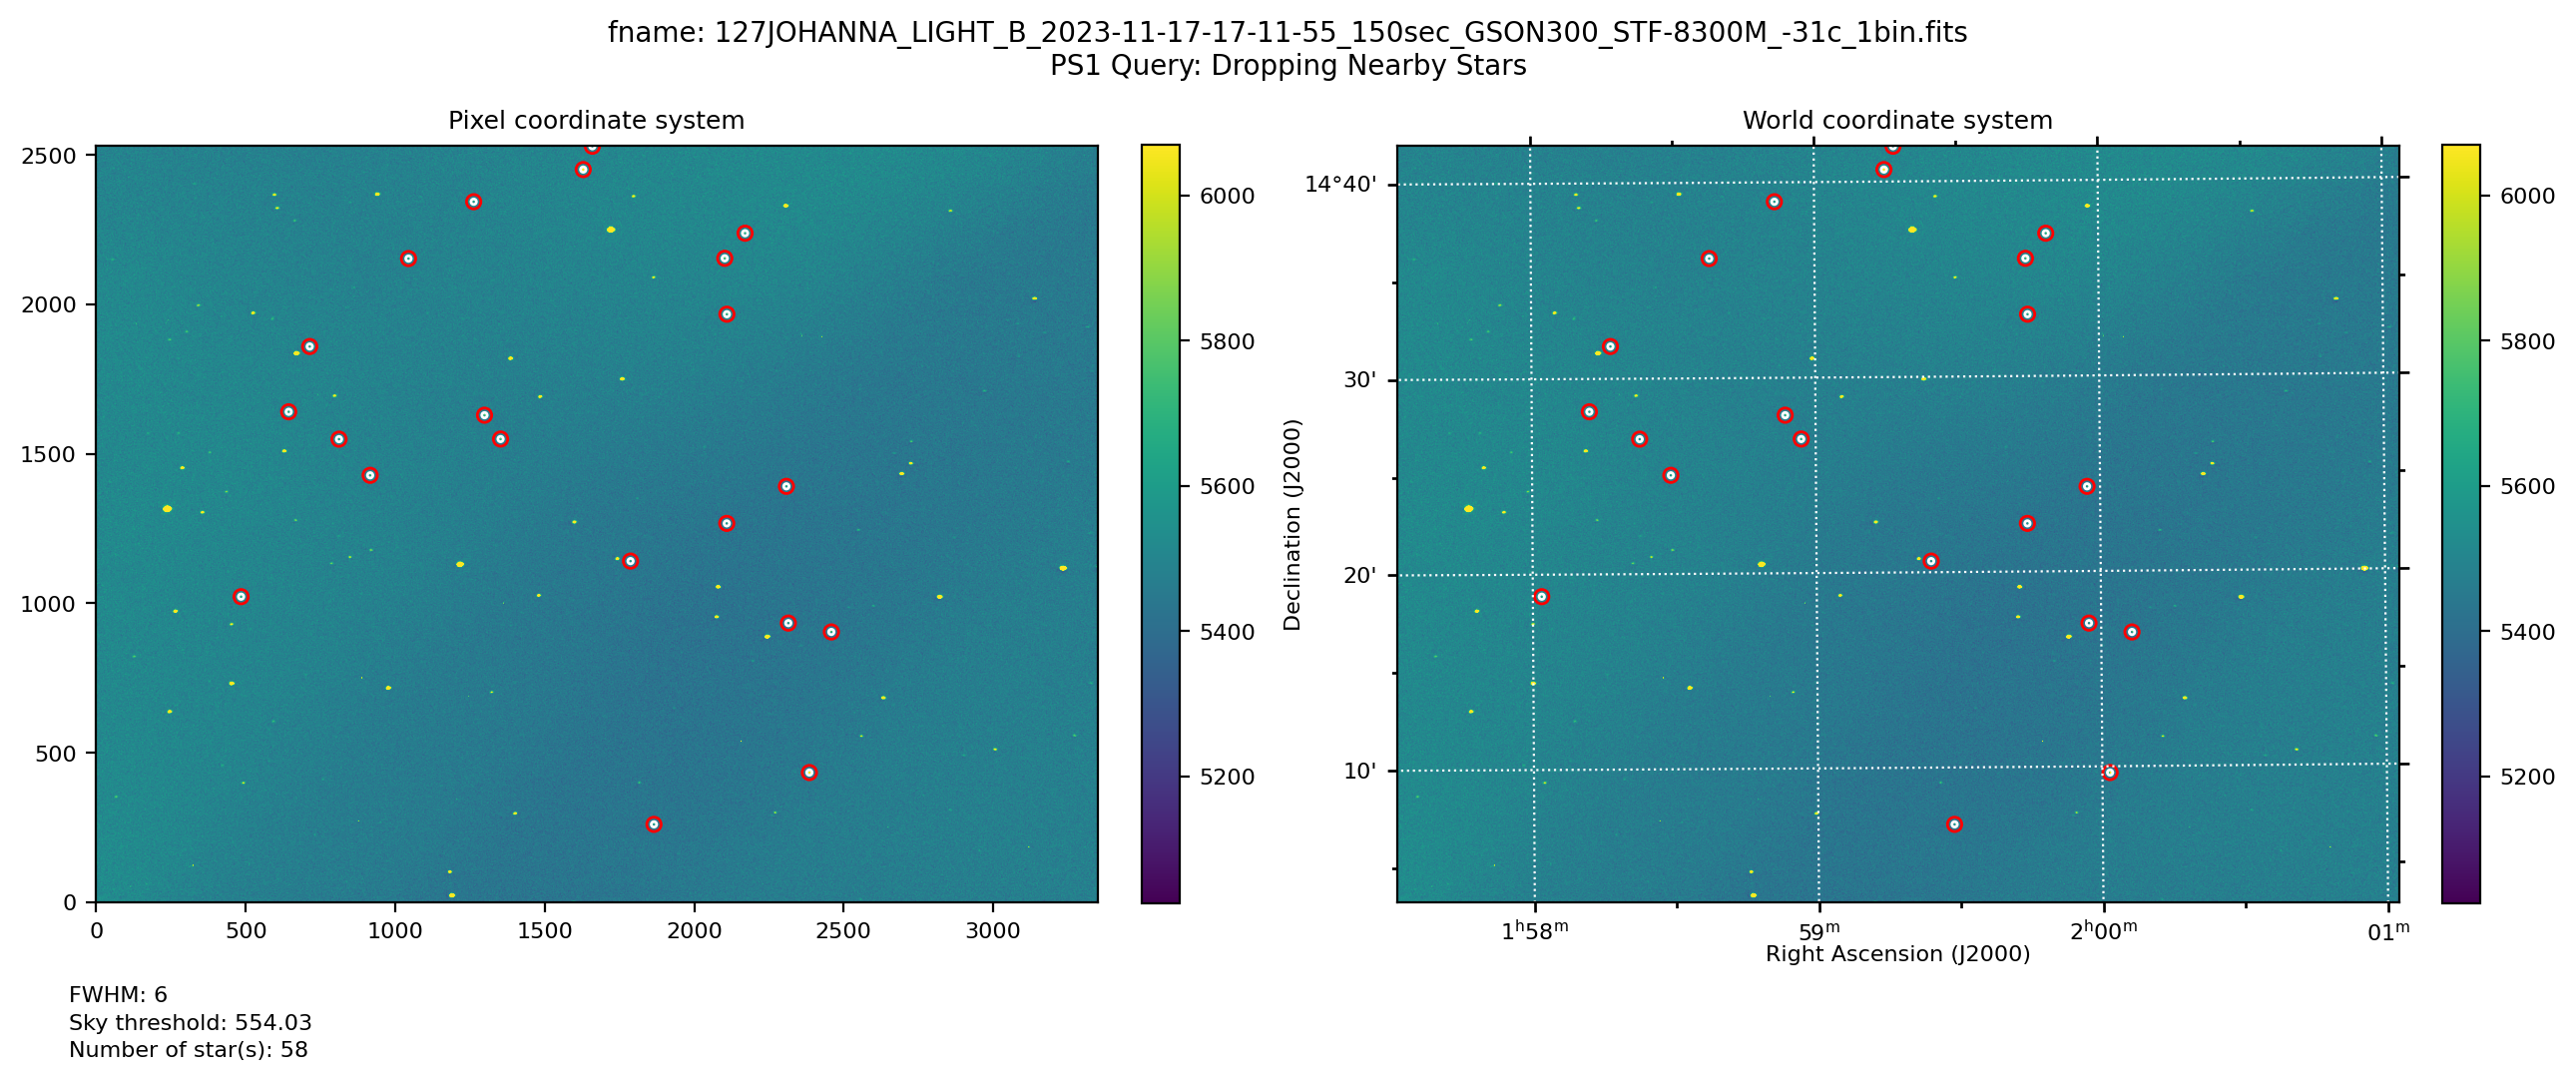

In [ ]:
ap_stars_orig = CAp(positions=pos_stars_orig, r=R_AP)
ap_stars = CAp(positions=pos_stars, r=R_IN)

fig_set = plt.figure(figsize=(13, 5.2))

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

ap_stars_orig.plot(ax1, color='w',
                    #lw=2,
                    )
ap_stars.plot(ax1, color='r',
                    #lw=2,
                    )
ap_stars_orig.plot(ax2, color='w',
                    #lw=2,
                    )
ap_stars.plot(ax2, color='r',
                    #lw=2,
                    )

cbar1 = plt.colorbar(im1, ax = ax1, fraction=0.035, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=0.035, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\nPS1 Query: Dropping Nearby Stars", fontsize=10,)

ax1.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_PS1_query.png")

plt.show()
#plt.close()

### 이미지에 있는 별과 매칭하기

In [ ]:
DAOfound
# Use ``DAOfound`` for aperture photometry:
coords_SF = np.array([DAOfound['xcentroid'], DAOfound['ycentroid']]).T

# %%
# Set the maximum allowable distance
match_distance = 50 # pixel  5

# Initialize some columns
for c in ["xcentroid", "ycentroid", "peak", "pixel_shift"]:
    q_stars[c] = np.nan

for i, coo in enumerate(q_stars):
    dx = np.abs(DAOfound['xcentroid'] - coo['x'])
    dy = np.abs(DAOfound['ycentroid'] - coo['y'])
    distances = np.sqrt(dx**2 + dy**2)
    accepted_SF = DAOfound[distances < match_distance]
    if len(accepted_SF) == 0:
        continue
    elif len(accepted_SF) > 1:
        raise ValueError(f"More than 1 star match for the {i}-th row!? Reduce match_distance.")
    else:
        q_stars[i]["pixel_shift"] = distances.min()
        q_stars[i]["xcentroid"] = DAOfound[distances.argmin()]["xcentroid"]
        q_stars[i]["ycentroid"] = DAOfound[distances.argmin()]["ycentroid"]
        q_stars[i]["peak"] = DAOfound[distances.argmin()]["peak"]

# Select only those which are matched
matched = q_stars[q_stars["pixel_shift"] < match_distance]
matched

<Table length=9>
   _r       RAJ2000       DEJ2000    ...       peak          pixel_shift    
              deg           deg      ...                                    
float64     float64       float64    ...     float64           float64      
-------- ------------- ------------- ... ---------------- ------------------
0.042573  29.850904940  14.342825120 ...  7285.0712890625  45.72172584354457
0.133505  29.723304010  14.468124020 ...  5888.0166015625  1.794963899899985
0.164432  29.988564090  14.405525000 ... 5792.64990234375 2.3922575514685422
0.210197  29.937386350  14.552659110 ... 5908.96923828125 1.9093088153570092
0.251163  29.935880850  14.600309060 ...      5803.546875 0.6973646276794033
0.278013  29.953944350  14.621563110 ... 5958.63623046875  2.125266609938784
0.278723  30.006752880  14.161283070 ...  6716.8603515625 1.4431498175565411
0.288035  29.569730530  14.527629230 ...  13512.595703125 49.899794738082846
0.302306  29.811814340  14.676882580 ... 13192.9423828125 0.8564430731078879

In [ ]:
df_stars
#df_stars.columns

_r    RAJ2000    DEJ2000               objID  cell  sky    f_objID  \
0   0.042573  29.850905  14.342825  125210298508911902  1597   52  503635968   
1   0.109658  29.737300  14.447707  125330297372917771  1597   62  503635968   
2   0.110453  29.935832  14.374357  125240299358089751  1597   51  503635968   
3   0.133505  29.723304  14.468124  125360297232912264  1597   62  503635968   
4   0.164432  29.988564  14.405525  125280299885217164  1597   61  503635968   
5   0.183580  29.989312  14.288918  125140299891067167  1597   51  503635968   
6   0.197995  29.622221  14.417492  125300296222081539  1597   62  503635968   
7   0.210197  29.937386  14.552659  125460299373613727  1597   61  503635968   
8   0.219834  30.027068  14.281050  125130300270327821  1597   51  503635968   
9   0.231720  29.595003  14.448483  125330295949818735  1597   62  503635968   
10  0.251163  29.935881  14.600309  125520299358520906  1597   61  503635968   
11  0.260796  29.869716  14.118102  124940298697462263  1597   52  235200512   
12  0.277570  29.657298  14.602053  125520296572642994  1597   62  503635968   
13  0.278013  29.953944  14.621563  125540299539216423  1597   61  503635968   
14  0.278723  30.006753  14.161283  124990300069854197  1597   51  839180288   
15  0.279909  29.550831  14.472072  125360295508097049  1597   62  503635968   
16  0.288035  29.569731  14.527629  125430295696973698  1597   62  503635968   
17  0.294169  29.715070  14.650154  125580297150410707  1597   62  503635968   
18  0.302306  29.811814  14.676883  125610298119532938  1597   62  302067712   
19  0.310065  29.507842  14.314602  125170295077918106  1597   52  503635968   
20  0.321976  29.819986  14.696703  125630298199856585  1597   62  503635968   

    Qual  e_RAJ2000  e_DEJ2000  ...  e_ymag  ymagStd  o_ymag   b_ymag  \
0     60     0.0137     0.0132  ...  0.0036   0.0134      10  13.9335   
1     60     0.0121     0.0215  ...  0.0076   0.0217      10  13.7566   
2     60     0.0041     0.0022  ...  0.0023   0.0078       7  13.9410   
3     60     0.0095     0.0220  ...  0.0037   0.0153      13  13.7597   
4     60     0.0046     0.0040  ...  0.0040   0.0111      11  13.6735   
5     60     0.0035     0.0039  ...  0.0079   0.0232      10  13.8383   
6     60     0.0074     0.0034  ...  0.0004   0.0013       5  13.7014   
7     60     0.0045     0.0076  ...  0.0042   0.0127       6  13.9541   
8     60     0.0086     0.0029  ...  0.0045   0.0149      10  13.7113   
9     60     0.0079     0.0098  ...  0.0025   0.0092      10  14.1404   
10    60     0.0058     0.0067  ...  0.0029   0.0078      10  13.7491   
11    28     0.0069     0.0083  ...  0.0050   0.0131       8  13.3627   
12    60     0.0080     0.0034  ...  0.0040   0.0188       8  13.6481   
13    60     0.0057     0.0044  ...  0.0016   0.0059       5  13.8487   
14   100     0.2197     0.0848  ...  0.0048   0.0137       8  12.7155   
15    60     0.0066     0.0048  ...  0.0025   0.0091      10  14.1793   
16    60     0.0055     0.0043  ...  0.0061   0.0147       9  13.6933   
17    60     0.0056     0.0027  ...  0.0024   0.0125      10  14.0549   
18    36     0.2599     0.2599  ...     NaN      NaN       0      NaN   
19    60     0.0250     0.0402  ...  0.0036   0.0114       9  13.4611   
20    60     0.0119     0.0028  ...  0.0018   0.0078       8  13.9453   

     B_ymag    yKmag  e_yKmag  yFlags            x            y  
0   13.9680  13.9864   0.0067  115000  1787.085623  1141.176880  
1   13.8143  13.7979   0.0012  115000  1352.393894  1549.465214  
2   13.9629  13.9650   0.0028  115000  2108.966424  1267.354809  
3   13.8067  13.7920   0.0048  115000  1298.668943  1629.195424  
4   13.7039  13.6926   0.0052  115000  2308.465092  1391.270938  
5   13.9035  13.8720   0.0039  115000  2315.013884   933.920998  
6   13.7039  13.7218   0.0031  115000   916.139532  1428.126362  
7   13.9896  14.0118   0.0039  115000  2109.416001  1966.983845  
8   13.7544  13.7386   0.0025  115000  2458.8822

/usr/local/lib/python3.10/dist-packages/ysphotutilpy/apphot.py:326: RuntimeWarning: invalid value encountered in log10
  phot["mag"] = -2.5*np.log10(phot['source_sum']/t_exposure)
/usr/local/lib/python3.10/dist-packages/ysphotutilpy/apphot.py:327: RuntimeWarning: divide by zero encountered in divide
  phot["merr"] = 2.5/np.log(10)*(1/snr)


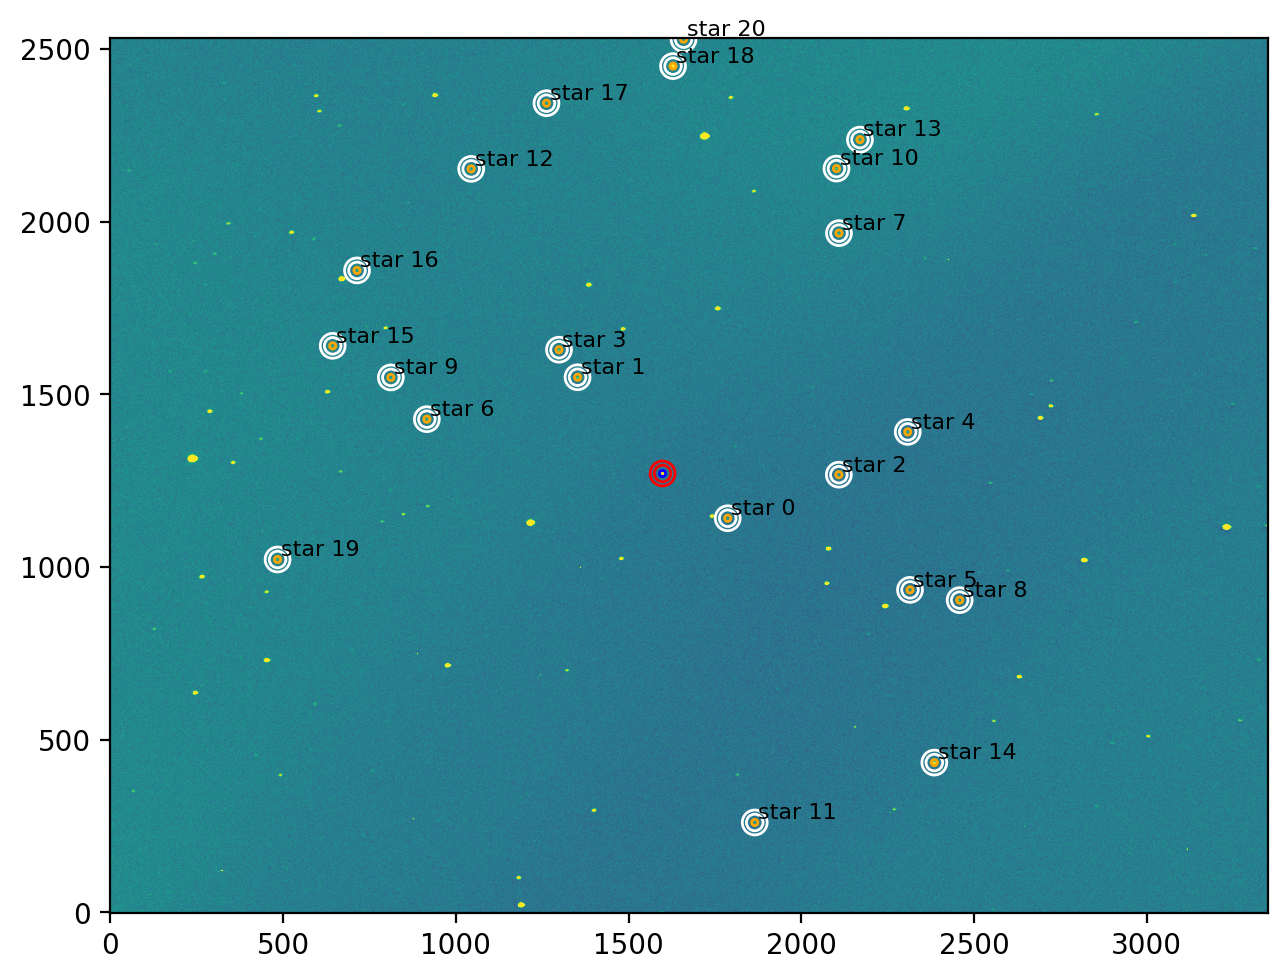

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

im = zimshow(axs, hdul[0].data)

targ_an.plot(axs, color="r")
targ_ap.plot(axs, color="b")

phot_targ = ypu.apphot_annulus(hdul[0].data, targ_ap, targ_an, error=yfu.errormap(hdul[0].data))
phot_targ

_phot_stars = []

for i, row in df_stars.iterrows():
    pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"],
                        **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
    ap = CAp([pos_star[0], pos_star[1]], r=R_AP)
    an = CAn([pos_star[0], pos_star[1]], r_in=R_IN, r_out=R_OUT)
    _phot_star = ypu.apphot_annulus(hdul[0].data, ap, an, error=yfu.errormap(hdul[0].data))
    _phot_star["Rmag"] = row["rmag"]
    _phot_star["e_Rmag"] = row["e_rmag"]
    _phot_star["grcolor"] = row["gmag"] - row["rmag"] #row["grcolor"]
    _phot_star["e_grcolor"] = row["e_gmag"] + row["e_rmag"]
    _phot_star["id"] = i
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    axs.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
    ap.plot(axs, color="orange")
    an.plot(axs, color="w")

plt.tight_layout()
plt.show();


### Standardization Plots

In [ ]:
df_phot_stars = pd.concat(_phot_stars)
df_phot_stars = df_phot_stars.dropna()
#phot_stars = phot_stars.loc[phot_stars["objID"] != 125240299358089744].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
#df_phot_stars = df_phot_stars.set_index('id', drop=True)
df_phot_stars

id      xcenter      ycenter  aperture_sum  aperture_sum_err         msky  \
0   0  1787.081591  1141.170477  1.397232e+06       1182.045528  5459.005452   
0   1  1352.361307  1549.425239  1.415863e+06       1189.900377  5473.731228   
0   2  2108.894475  1267.303697  1.391781e+06       1179.737533  5451.836312   
0   3  1298.624222  1629.134921  1.414988e+06       1189.532650  5474.379101   
0   4  2308.295700  1391.139285  1.397369e+06       1182.103708  5468.262301   
0   5  2314.883346   933.812687  1.391153e+06       1179.471484  5457.399555   
0   6   915.938532  1427.986055  1.410078e+06       1187.467186  5471.087642   
0   7  2109.231719  1966.677882  1.410275e+06       1187.550060  5479.706606   
0   8  2458.683961   904.120312  1.397629e+06       1182.213594  5463.669863   
0   9   811.730535  1548.875818  1.406794e+06       1186.083664  5469.963098   
0  10  2102.027230  2153.524774  1.422113e+06       1192.523905  5482.066836   
0  11  1865.342353   260.305231  1.393884e+06       1180.628561  5465.356332   
0  12  1044.332550  2152.738821  1.410264e+06       1187.545538  5469.044497   
0  13  2169.935539  2237.426482  1.414972e+06       1189.525938  5475.295474   
0  14  2385.329528   433.744969  1.457446e+06       1207.247100  5470.385462   
0  15   643.331034  1640.350292  1.410846e+06       1187.790583  5480.455576   
0  16   713.738965  1858.702686  1.413229e+06       1188.793152  5475.156861   
0  17  1262.346431  2342.879463  1.407881e+06       1186.541492  5468.024595   
0  19   483.795648  1021.731254  1.411628e+06       1188.119515  5471.104109   

         ssky  nsky  nrej      aparea  ...        mag      merr        snr  \
0  106.124876  2247    15  254.469005  ...  -9.769058  0.277312   3.915220   
0  103.114405  2247    17  254.469005  ... -10.902806  0.095969  11.313412   
0  104.280571  2250    10  254.469005  ...  -9.122676  0.496761   2.185630   
0  102.327681  2240    22  254.469005  ... -10.852504  0.100006  10.856675   
0  104.754092  2252     8  254.469005  ...  -9.420839  0.378864   2.865766   
0  106.986788  2242    12  254.469005  ...  -8.456820  0.933093   1.163588   
0  110.568469  2246    16  254.469005  ... -10.629466  0.129288   8.397813   
0  106.553709  2254     8  254.469005  ... -10.500734  0.141950   7.648706   
0  106.487013  2246    14  254.469005  ...  -9.657466  0.308050   3.524549   
0  106.714061  2247    12  254.469005  ... -10.429930  0.151608   7.161474   
0  107.880372  2246    15  254.469005  ... -11.082310  0.083892  12.942111   
0  108.926708  2255    12  254.469005  ...  -8.735391  0.731043   1.485187   
0  111.020053  2251    11  254.469005  ... -10.671567  0.124723   8.705192   
0  106.721708  2236    23  254.469005  ... -10.840096  0.104013  10.438453   
0  107.472557  2241    21  254.469005  ... -12.038978  0.034809  31.191058   
0  106.285970  2250    18  254.469005  ... -10.526491  0.138398   7.845043   
0  107.172438  2246    16  254.469005  ... -10.751023  0.113204   9.590972   
0  109.346001  2254     7  254.469005  ... -10.539618  0.139341   7.791933   
0  105.516077  2250    13  254.469005  ... -10.719592  0.115296   9.416908   

   bad  nbadpix     Rmag  e_Rmag  grcolor  e_grcolor               objID  
0    0        0  14.2486  0.0035   0.4297     0.0068  125210298508911904  
0    0        0  13.9318  0.0022   0.3299     0.0094  125330297372917776  
0    0        0  14.2740  0.0034   0.4850     0.0075  125240299358089744  
0    0        0  13.9193  0.0008   0.3334     0.0115  125360297232912256  
0    0        0  13.9650  0.0009   0.4402     0.0050  125280299885217168  
0    0        0  14.1741  0.0005   0.4169     0.0016  125140299891067168  
0    0        0  14.0136  0.0057   0.5005     0.0084  125300296222081536  
0    0        0  14.1544  0.0098   0.3546     0.0254  125460299373613728  
0    0        0  13.9925  0.0041   0.4036     0.0048  125130300270327824  
0    0        0  14.4062  0.0036   0.4407     0.0103  125330295949818736  
0    0        0 

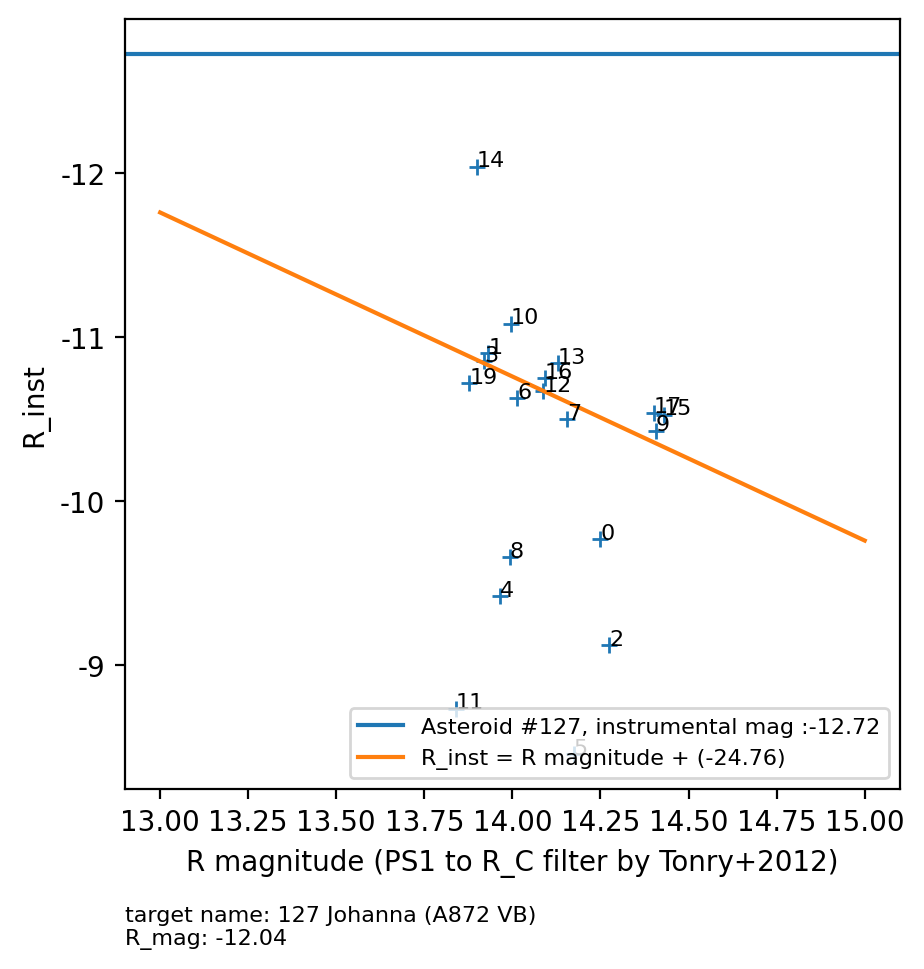

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5),
                        sharex=False, sharey=False, gridspec_kw=None)

_xx = np.linspace(13, 15)
axs.plot(df_phot_stars["Rmag"], df_phot_stars["mag"], '+')
axs.axhline(phot_targ["mag"].values,
            label=f"Asteroid #{OBJID}, instrumental mag :{float(phot_targ['mag'].values):.02f}")
axs.plot(_xx, _xx + np.median(df_phot_stars['mag'] - df_phot_stars['Rmag']),
         label=f"R_inst = R magnitude + ({np.median(df_phot_stars['mag'] - df_phot_stars['Rmag']):.02f})")

for _, row in df_phot_stars.iterrows():
    axs.text(row["Rmag"], row["mag"], int(row["id"]), fontsize=8)

axs.set(
    xlabel="R magnitude (PS1 to R_C filter by Tonry+2012)",
    ylabel="R_inst"
)

axs.invert_yaxis()
axs.legend(fontsize="8", loc ="lower right")

axs.annotate(f"target name: {df_eph['targetname'][0]}\nR_mag: {np.median(df_phot_stars['mag'] - df_phot_stars['Rmag'])- phot_targ['mag'][0]:.02f}",
             fontsize=8,
    xy=(0, 0), xytext=(0, -0.15), va='top', ha='left',
    xycoords='axes fraction')

plt.show()

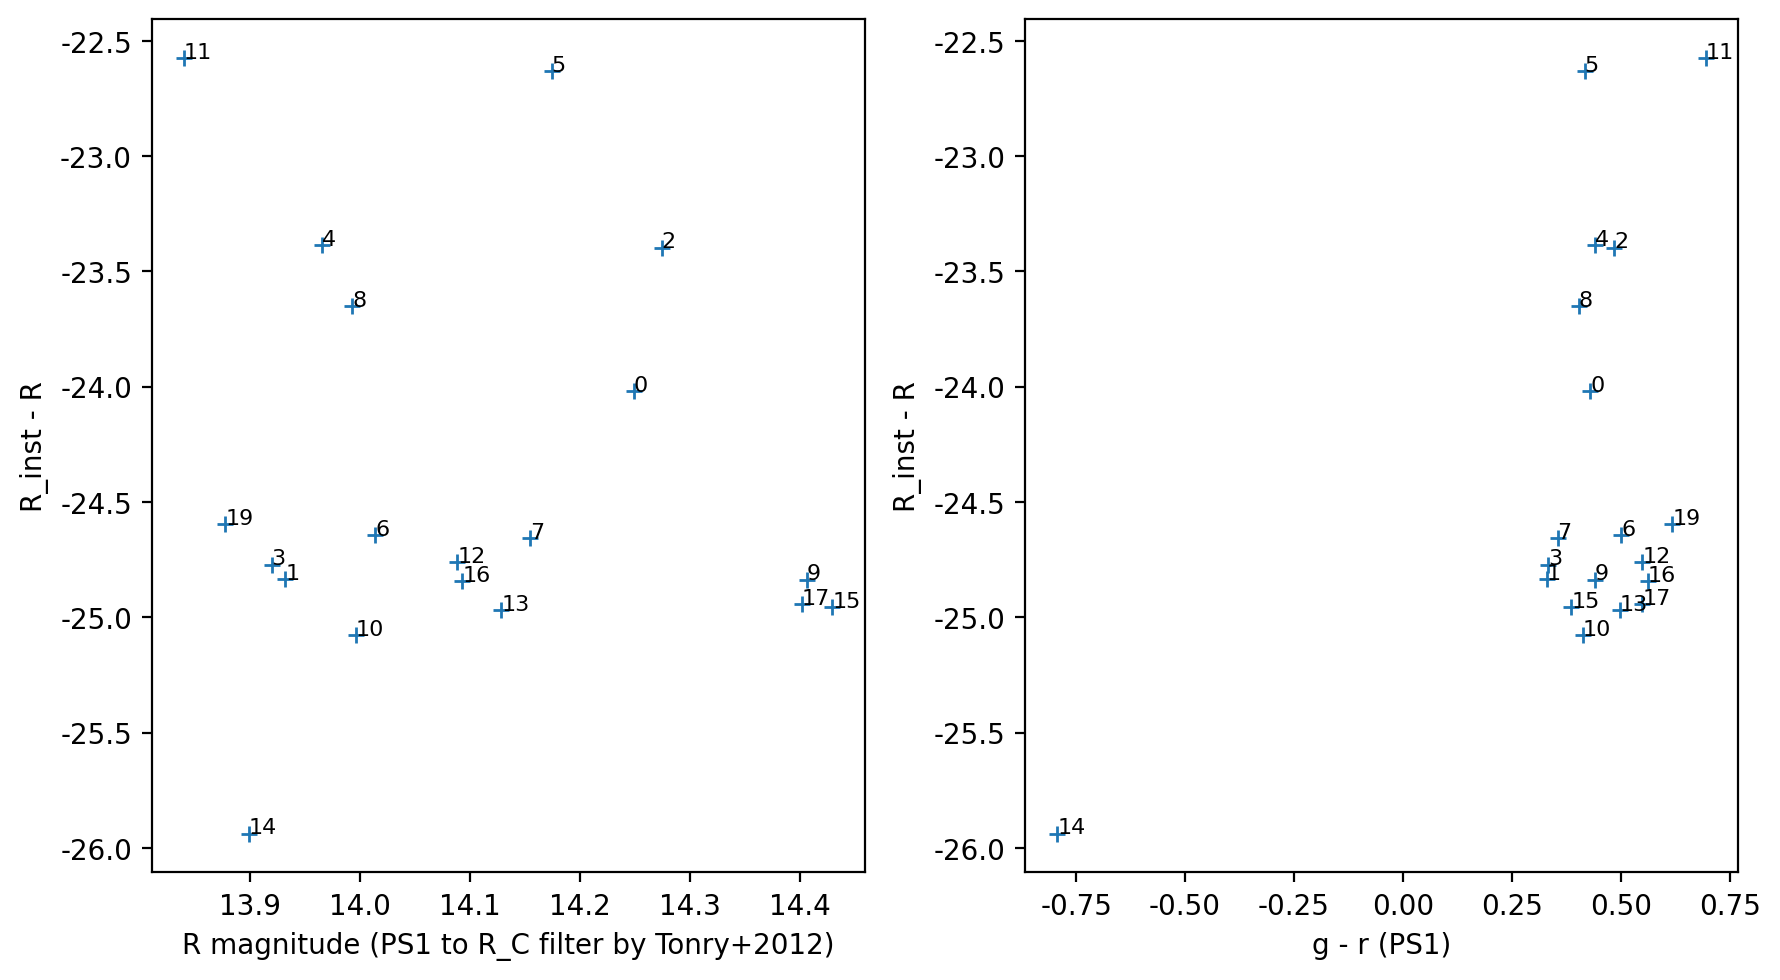

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5),
                        sharex=False, sharey=False, gridspec_kw=None)

axs[0].plot(df_phot_stars["Rmag"], df_phot_stars["mag"] - df_phot_stars["Rmag"], '+')
axs[1].plot(df_phot_stars["grcolor"], df_phot_stars["mag"] - df_phot_stars["Rmag"], '+')
for _, row in df_phot_stars.iterrows():
    axs[0].text(row["Rmag"], row["mag"] - row["Rmag"], int(row["id"]), fontsize=8)
    axs[1].text(row["grcolor"], row["mag"] - row["Rmag"], int(row["id"]), fontsize=8)

axs[0].set(
    xlabel="R magnitude (PS1 to R_C filter by Tonry+2012)",
    ylabel="R_inst - R"
)
axs[1].set(
    xlabel="g - r (PS1)",
    ylabel="R_inst - R"
)

plt.tight_layout()
plt.show();

(과제) 관측한 소행성의 등급을 결정해 보시오.


In [ ]:
#(과제) 이곳에 코딩을 완성하여 제출하시오.